In [0]:
pwd

'/content'

In [0]:
from google.colab import drive
drive.mount('./drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./drive


In [0]:
!ls './drive/My Drive/Thesis Work'

 CambridgeMonoPhoneDf.pickle	      Implementation4
 CambridgeWordFeaturesDf.pickle       jawadmodel2.h5
 CheckScrapSpeed.ipynb		      L2monoPhoneDfTest.pickle
 ConvertToWav.ipynb		      L2monoPhoneDfTrain.pickle
'Copy of l2arctic_release_v2.0.zip'   L2WordFeaturesDfTest.pickle
 DelIfCopiesFine.ipynb		      L2WordFeaturesDfTrain.pickle
 Implementation1		      MostCommon3000Oxford.txt
 Implementation2		      UKpronunciations
 Implementation3		      USpronunciations


Bism  
# Imports

In [2]:
import pandas as pd
import numpy as np
import os
import IPython.display as ipd
import librosa
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')
from tqdm import tqdm_notebook


#SKLEARN
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as sklm
from sklearn.manifold import TSNE

#KERAS
from keras import models
from keras.models import Model, load_model
from keras import callbacks
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


# Implementation 3  (PHONE LEVEL)
## Using Cambridge as Training set
## L2 as val+test set

### Training

#### X_TRAIN

In [0]:
train_featureDf = pd.read_pickle("./drive/My Drive/Thesis Work/CambridgeMonoPhoneDf.pickle")
train_featureDf['deltaC'] = train_featureDf.MFCCs.apply(librosa.feature.delta)
train_featureDf['doubleDeltaC'] = train_featureDf.MFCCs.apply(librosa.feature.delta, order=2)

In [0]:
train_featureDf.head()

,phones,n_frames,MFCCs,deltaC,doubleDeltaC
0,EY1,25578,"[[-291.8450070479023, -217.19829270139564, -19...","[[9.487662000232724, 9.487662000232724, 9.4876...","[[-6.376473820510356, -6.376473820510356, -6.3..."
1,AH0,25578,"[[-225.94958932571305, -230.66110818062165, -2...","[[-54.921112440073244, -54.921112440073244, -5...","[[-18.50104924335272, -18.50104924335272, -18...."
2,B,25578,"[[-432.10191013546967, -447.45165708166746, -4...","[[-11.923153139484537, -11.923153139484537, -1...","[[2.9347052509706972, 2.9347052509706972, 2.93..."
3,AE1,25578,"[[-163.8074117674994, -163.57078049895233, -17...","[[-2.148061613459353, -2.148061613459353, -2.1...","[[-0.19780780635970172, -0.19780780635970172, ..."
4,N,25578,"[[-161.45519234092518, -171.98276211855284, -2...","[[-8.976744094194295, -8.976744094194295, -8.9...","[[5.066161955152742, 5.066161955152742, 5.0661..."


In [0]:
#remove stresses
train_featureDf.phones = [''.join([alpha for alpha in phone if alpha.isalpha()]) for phone in train_featureDf.phones]

In [0]:
train_featureDf.head()

,phones,n_frames,MFCCs,deltaC,doubleDeltaC
0,EY,25578,"[[-291.8450070479023, -217.19829270139564, -19...","[[9.487662000232724, 9.487662000232724, 9.4876...","[[-6.376473820510356, -6.376473820510356, -6.3..."
1,AH,25578,"[[-225.94958932571305, -230.66110818062165, -2...","[[-54.921112440073244, -54.921112440073244, -5...","[[-18.50104924335272, -18.50104924335272, -18...."
2,B,25578,"[[-432.10191013546967, -447.45165708166746, -4...","[[-11.923153139484537, -11.923153139484537, -1...","[[2.9347052509706972, 2.9347052509706972, 2.93..."
3,AE,25578,"[[-163.8074117674994, -163.57078049895233, -17...","[[-2.148061613459353, -2.148061613459353, -2.1...","[[-0.19780780635970172, -0.19780780635970172, ..."
4,N,25578,"[[-161.45519234092518, -171.98276211855284, -2...","[[-8.976744094194295, -8.976744094194295, -8.9...","[[5.066161955152742, 5.066161955152742, 5.0661..."


In [0]:
train_featureDf.phones.nunique() #39 phones

39

In [0]:
x_train = np.array((train_featureDf.MFCCs,train_featureDf.deltaC,train_featureDf.doubleDeltaC))
x_train.shape

(3, 18521, 13, 50)

In [0]:
x_train = np.transpose(x_train,[1,2,3,0])
x_train.shape

(18521, 13, 50, 3)

In [0]:
np.save('./drive/My Drive/Thesis Work/Implementation3/x_train.npy',x_train) #Feature vector

_______

#### Y_TRAIN

In [0]:
train_phones = np.array(train_featureDf.phones)
np.save('./drive/My Drive/Thesis Work/Implementation3/train_phones.npy', train_phones)

In [0]:
encoder = LabelBinarizer()
y_train = encoder.fit_transform(train_phones)
y_train.shape

(18521, 39)

In [0]:
np.save('./drive/My Drive/Thesis Work/Implementation3/y_train.npy',y_train) #save y_train

#### MODEL

In [0]:
x_train = np.load("./drive/My Drive/Thesis Work/Implementation3/x_train.npy")
y_train = np.load("./drive/My Drive/Thesis Work/Implementation3/y_train.npy")
model = load_model("./drive/My Drive/Thesis Work/Implementation3/model.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 13, 50, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 25, 32)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 25, 64)         18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 23, 64)         36928     
_________________________________________________________________
average_pooling2d_2 (Average (None, 2, 11, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1408)              0         
__________

In [0]:
model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3),padding='same', activation='relu', input_shape=(13, 50, 3)))
model.add(Conv2D(32, (3, 3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(42, activation='softmax'))


callbacklist=[callbacks.History(),callbacks.ModelCheckpoint('./jawadmodel.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=5)]
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=20794, epochs=500, callbacks=callbacklist)

In [0]:
callbacklist=[callbacks.History(),callbacks.ModelCheckpoint('./jawadmodel.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=5)]
model.fit(x_train, y_train, batch_size=20794, epochs=5, callbacks=callbacklist)

Epoch 1/5
20794/20794 [==============================] - 3s 145us/step - loss: 0.0055 - acc: 0.9996
Epoch 2/5
20794/20794 [==============================] - 3s 152us/step - loss: 0.0055 - acc: 0.9996
Epoch 3/5
20794/20794 [==============================] - 3s 148us/step - loss: 0.0055 - acc: 0.9996
Epoch 4/5
20794/20794 [==============================] - 3s 147us/step - loss: 0.0055 - acc: 0.9996
Epoch 5/5
20794/20794 [==============================] - 3s 147us/step - loss: 0.0055 - acc: 0.9996

Epoch 00005: loss improved from inf to 0.00551, saving model to ./jawadmodel.h5


AH

In [0]:
!cp ./jawadmodel.h5 "./drive/My Drive/Thesis Work/Implementation3/model.h5"

In [0]:
!ls "./drive/My Drive/Thesis Work/Implementation3/"

model.h5  train_phones.npy  x_train.npy  y_train.npy


### TESTING

#### Representation Layer, L2 norm, Prediction Checks

In [0]:
!ls './drive/My Drive/Thesis Work/Implementation3'

model.h5	 test_phones.npy       train_phones.npy  x_train.npy
test_labels.npy  test_typeOfError.npy  x_test.npy	 y_train.npy


loss: 0.0055 - acc: 100% ==> Trained Model (Cambrige Phones)

In [0]:
train_phones = np.load("./drive/My Drive/Thesis Work/Implementation3/train_phones.npy") #vocabulary

In [0]:
encoder = LabelBinarizer()
encoder.fit(train_phones)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [0]:
encoder.inverse_transform(model.predict(x_train[:4])) #predicting correctly

array(['EY', 'sp', 'sil', 'AH'], dtype='<U3')

In [0]:
encoder.inverse_transform(y_train[:4])

array(['EY', 'sp', 'sil', 'AH'], dtype='<U3')

In [0]:
np.all(encoder.inverse_transform(y_train) == train_phones) #decoder also working fine

True

In [0]:
model.layers[-2] #representation

In [0]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(index=-2).output)

In [0]:
np.linalg.norm(intermediate_layer_model.predict(x_train[1:2]) - intermediate_layer_model.predict(x_train[1:2])) #l2 norm

0.0

In [0]:
intermediate_layer_model.predict(x_train[0:1]).shape

(1, 50)

#### CREATING TEST ARRAYS

In [0]:
!ls './drive/My Drive/Thesis Work/'

 CambridgeMonoPhoneDf.pickle	      jawadmodel2.h5
 CambridgeWordFeaturesDf.pickle       L2monoPhoneDfTest.pickle
 CheckScrapSpeed.ipynb		      L2monoPhoneDfTrain.pickle
 ConvertToWav.ipynb		      L2WordFeaturesDfTest.pickle
'Copy of l2arctic_release_v2.0.zip'   L2WordFeaturesDfTrain.pickle
 Implementation1		      ModelFitting.ipynb
 Implementation2		      MostCommon3000Oxford.txt
 Implementation3		      UKpronunciations
 Implementation4		      USpronunciations


In [0]:
test_featureDf = pd.read_pickle("./drive/My Drive/Thesis Work/L2monoPhoneDfTest.pickle")
test_featureDf['deltaC'] = test_featureDf.MFCCs.apply(librosa.feature.delta)
test_featureDf['doubleDeltaC'] = test_featureDf.MFCCs.apply(librosa.feature.delta, order=2)

In [0]:
test_featureDf.head()

,phones,n_frames,labels,errorType,MFCCs,deltaC,doubleDeltaC
0,G,25578,1,c,"[[-423.77322755406794, -411.9959932464969, -41...","[[22.30071061887127, 22.30071061887127, 22.300...","[[9.696126870518793, 9.696126870518793, 9.6961..."
1,AA1,25578,1,c,"[[-221.94339159438036, -221.9371806257653, -22...","[[-11.524404444499647, -11.524404444499647, -1...","[[-9.99426568613695, -9.99426568613695, -9.994..."
2,D,25578,1,c,"[[-325.1734666200506, -337.9629833826362, -363...","[[-15.686472752824017, -15.686472752824017, -1...","[[1.1662679563218068, 1.1662679563218068, 1.16..."
3,B,25578,1,c,"[[-447.436674575593, -452.4805757789892, -464....","[[-34.72703866334349, -34.72703866334349, -34....","[[-34.82559064172156, -34.82559064172156, -34...."
4,L,25578,1,c,"[[-292.9672733282472, -267.3215759439314, -275...","[[-3.6625277966476957, -3.6625277966476957, -3...","[[7.597755619620679, 7.597755619620679, 7.5977..."


In [0]:
print("Test Phones: ", len(test_featureDf.phones))
print("Unique Test Phones: ", len(set(test_featureDf.phones)))

Test Phones:  34799
Unique Test Phones:  71


In [0]:
test_featureDf.phones = [''.join([alpha for alpha in phone if alpha.isalpha()]) for phone in test_featureDf.phones]

In [0]:
test_featureDf.head()

,phones,n_frames,labels,errorType,MFCCs,deltaC,doubleDeltaC
0,G,25578,1,c,"[[-423.77322755406794, -411.9959932464969, -41...","[[22.30071061887127, 22.30071061887127, 22.300...","[[9.696126870518793, 9.696126870518793, 9.6961..."
1,AA,25578,1,c,"[[-221.94339159438036, -221.9371806257653, -22...","[[-11.524404444499647, -11.524404444499647, -1...","[[-9.99426568613695, -9.99426568613695, -9.994..."
2,D,25578,1,c,"[[-325.1734666200506, -337.9629833826362, -363...","[[-15.686472752824017, -15.686472752824017, -1...","[[1.1662679563218068, 1.1662679563218068, 1.16..."
3,B,25578,1,c,"[[-447.436674575593, -452.4805757789892, -464....","[[-34.72703866334349, -34.72703866334349, -34....","[[-34.82559064172156, -34.82559064172156, -34...."
4,L,25578,1,c,"[[-292.9672733282472, -267.3215759439314, -275...","[[-3.6625277966476957, -3.6625277966476957, -3...","[[7.597755619620679, 7.597755619620679, 7.5977..."


In [0]:
test_featureDf.phones.nunique()

42

In [0]:
x_test = np.array((test_featureDf.MFCCs,test_featureDf.deltaC,test_featureDf.doubleDeltaC))
x_test.shape

(3, 34799, 13, 50)

In [0]:
x_test = np.transpose(x_test,[1,2,3,0])

In [0]:
x_test.shape

(34799, 13, 50, 3)

In [0]:
test_phones = np.array(test_featureDf.phones)
test_labels = np.array(test_featureDf['labels'])
print(test_phones.shape)
print(test_labels.shape)

(34799,)
(34799,)


In [0]:
np.save('./drive/My Drive/Thesis Work/Implementation3/x_test.npy',x_test)
np.save('./drive/My Drive/Thesis Work/Implementation3/test_labels.npy',test_labels)
np.save('./drive/My Drive/Thesis Work/Implementation3/test_phones.npy',test_phones)

#### LOADING ARRAYS, VALIDATION AND TESTING

In [0]:
!ls './drive/My Drive/Thesis Work/Implementation3/'

model.h5	 test_phones.npy       train_phones.npy  x_train.npy
test_labels.npy  test_typeOfError.npy  x_test.npy	 y_train.npy


In [3]:
x_train = np.load('./drive/My Drive/Thesis Work/PhoneLevel_RL_MFCC_TrainCamb_TestL2/x_train.npy')
train_phones = np.load('./drive/My Drive/Thesis Work/PhoneLevel_RL_MFCC_TrainCamb_TestL2/train_phones.npy')
y_train = np.load('./drive/My Drive/Thesis Work/PhoneLevel_RL_MFCC_TrainCamb_TestL2/y_train.npy')


model = load_model('./drive/My Drive/Thesis Work/PhoneLevel_RL_MFCC_TrainCamb_TestL2/model.h5')
encoder = LabelBinarizer()
encoder.fit(train_phones)
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(index=-2).output)


x_test = np.load('./drive/My Drive/Thesis Work/PhoneLevel_RL_MFCC_TrainCamb_TestL2/x_test.npy')
test_labels = np.load('./drive/My Drive/Thesis Work/PhoneLevel_RL_MFCC_TrainCamb_TestL2/test_labels.npy')
test_phones = np.load('./drive/My Drive/Thesis Work/PhoneLevel_RL_MFCC_TrainCamb_TestL2/test_phones.npy')
test_typeOfError = np.load('./drive/My Drive/Thesis Work/PhoneLevel_RL_MFCC_TrainCamb_TestL2/test_typeOfError.npy')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [4]:
train_phones.shape #camridge

(20794,)

In [5]:
test_phones.shape #l2

(34799,)

In [6]:
train_representations = intermediate_layer_model.predict(x_train)
train_representations.shape

(20794, 50)

In [7]:
[p for p in test_phones if p not in train_phones] #Only AX not in train

['AX']

In [8]:
#VALIDATION

valSetLength = 6000 #initial some from test

truelabels = [test_labels[i] for i in range(valSetLength) if test_phones[i] in train_phones]

accs = []
f1mis = []
for threshold in [90,100,110,120,130,140,150,160]:
  predictedLabels = []
  for i in range(valSetLength): #iterating on test phones
    if test_phones[i] in train_phones:
      '''print(i)
      print(test_phones[i])
      print(test_labels[i])
      print(np.mean(np.linalg.norm(train_representations[np.argwhere(train_phones == test_phones[i]).reshape(-1,)]\
                       - intermediate_layer_model.predict(x_test[i:i+1]),axis=1)))'''
      if np.mean(np.linalg.norm(train_representations[np.argwhere(train_phones == test_phones[i]).reshape(-1,)]\
                       - intermediate_layer_model.predict(x_test[i:i+1]),axis=1)) <= threshold:
        predictedLabels.append(1)
      else: 
        predictedLabels.append(0)

  accs.append(sklm.accuracy_score(truelabels,predictedLabels))
  f1mis.append(sklm.precision_recall_fscore_support(truelabels,predictedLabels)[2][0])

print("Threshold: ", np.argmax(f1mis))
print("Max Achievable Accuracy: ", accs[np.argmax(f1mis)])
print("Max Achievable F-1 score for Mispronunciations: ", max(f1mis))

Threshold:  3
Max Achievable Accuracy:  0.43133333333333335
Max Achievable F-1 score for Mispronunciations:  0.2743513398553807


In [0]:
#TESTING

valSetLength = 6000 #initial some from test
threshold = 120
truelabels = [test_labels[i] for i in range(valSetLength,test_phones.shape[0]) if test_phones[i] in train_phones]

predictedLabels = []
for i in range(valSetLength,test_phones.shape[0]): #iterating on test words
  if test_phones[i] in train_phones:
    '''print(i)
    print(test_phones[i])
    print(test_labels[i])
    print(np.mean(np.linalg.norm(train_representations[np.argwhere(train_phones == test_phones[i]).reshape(-1,)]\
                     - intermediate_layer_model.predict(x_test[i:i+1]),axis=1)))'''
    if np.mean(np.linalg.norm(train_representations[np.argwhere(train_phones == test_phones[i]).reshape(-1,)]\
                     - intermediate_layer_model.predict(x_test[i:i+1]),axis=1)) <= threshold:
      predictedLabels.append(1)
    else: 
      predictedLabels.append(0)

In [10]:
print('Accuracy = ', sklm.accuracy_score(truelabels,predictedLabels))
sklm.precision_recall_fscore_support(truelabels,predictedLabels) #0 - 1

Accuracy =  0.4402041808458921


(array([0.13656536, 0.93170865]),
 array([0.76398492, 0.39998438]),
 array([0.23171139, 0.55969191]),
 array([ 3182, 25616]))

In [11]:
print(sklm.classification_report(truelabels, predictedLabels, target_names=['Mispronounced','Correct']))
print(sklm.confusion_matrix(truelabels, predictedLabels, labels=range(2)))

print(sklm.roc_curve(truelabels,predictedLabels))
print('FAR = ', sklm.roc_curve(truelabels,predictedLabels)[0][1]*100,'%')
print('FRR = ', (1 - sklm.roc_curve(truelabels,predictedLabels)[1][1])*100,'%')
print("AUC_SCORE = ", sklm.roc_auc_score(truelabels,predictedLabels)*100,'%')

               precision    recall  f1-score   support

Mispronounced       0.14      0.76      0.23      3182
      Correct       0.93      0.40      0.56     25616

    micro avg       0.44      0.44      0.44     28798
    macro avg       0.53      0.58      0.40     28798
 weighted avg       0.84      0.44      0.52     28798

[[ 2431   751]
 [15370 10246]]
(array([0.        , 0.23601508, 1.        ]), array([0.        , 0.39998438, 1.        ]), array([2, 1, 0]))
FAR =  23.601508485229417 %
FRR =  60.001561524047474 %
AUC_SCORE =  58.198464995361554 %


### Results

In [0]:
print('Accuracy = ', sklm.accuracy_score(truelabels,predictedLabels))

Accuracy =  0.4402041808458921


In [0]:
sklm.precision_recall_fscore_support(truelabels,predictedLabels) #0 - 1

(array([0.13656536, 0.93170865]),
 array([0.76398492, 0.39998438]),
 array([0.23171139, 0.55969191]),
 array([ 3182, 25616]))

In [0]:
sklm.precision_recall_fscore_support(truelabels,predictedLabels)[2][0] #0

0.2317113854072344

In [0]:
sklm.roc_curve(truelabels,predictedLabels)

(array([0.        , 0.23601508, 1.        ]),
 array([0.        , 0.39998438, 1.        ]),
 array([2, 1, 0]))

*CANNOT COMPARE RESULTS:*  
The Interspeech one has a **different dataset** and shows results on phone level (as every phone is a separate class there)

The l2-arctic one shows no results

I am the first one to show results on this dataset

**Results are not quite good. Have to visualize what in the world is going on**

In [0]:
train_representations2D = TSNE(n_components=2).fit_transform(train_representations)
train_representations2D.shape

(20794, 2)

In [0]:
test_representations = intermediate_layer_model.predict(x_test)
test_representations2D = TSNE(n_components=2).fit_transform(test_representations)
test_representations2D.shape

(34799, 2)

In [0]:
np.save("./drive/My Drive/Thesis Work/Implementation3/test_representations2D.npy",test_representations2D)

In [0]:
train_representations2D = np.load("./drive/My Drive/Thesis Work/Implementation3/train_representations2D.npy")

In [0]:
print(set(test_phones))

{'D', 'JH', 'Z', 'OW', 'N', 'UW', 'IY', 'SH', 'AW', 'EH', 'R', 'AY', 'B', 'HH', 'K', 'OY', 'Y', 'P', 'spn', 'DH', 'EY', 'TH', 'L', 'F', 'UH', 'IH', 'T', 'S', 'AO', 'AX', 'ER', 'V', 'G', 'AA', 'AH', 'W', 'CH', 'sil', 'M', 'AE', 'sp', 'NG'}


In [0]:
def scatterPlot(phone):
  plt.figure(figsize=(8,6))
  plt.title("Plot For Phone --> "+phone)
  mask = train_phones == phone
  plt.scatter(train_representations2D[mask,0],train_representations2D[mask,1], label = 'Train', c ='g')
  mask = (test_phones == phone) & (test_labels == 1)
  plt.scatter(test_representations2D[mask,0],test_representations2D[mask,1], label = 'Correct', c = 'b',marker='+')
  mask = (test_phones == phone) & (test_labels == 0)
  plt.scatter(test_representations2D[mask,0],test_representations2D[mask,1], label = 'Incorrect' ,c = 'r', marker='x')
  plt.legend()

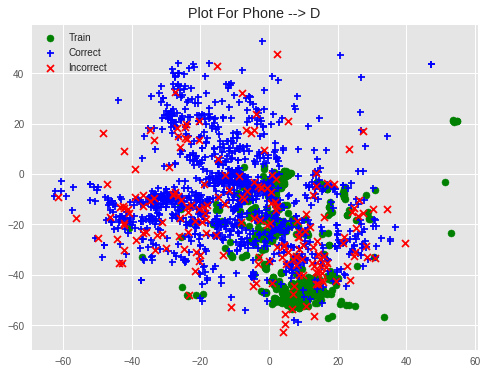

In [0]:
scatterPlot('D')

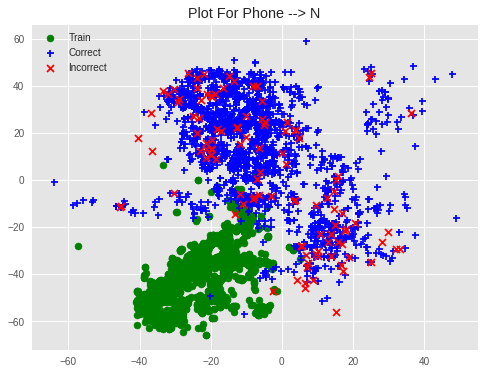

In [0]:
scatterPlot('N')

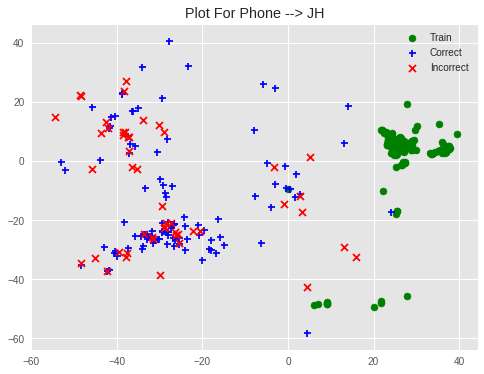

In [0]:
scatterPlot('JH')